<a href="https://colab.research.google.com/github/SeongminCC/PyTorch_project/blob/main/2_VGGnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# modules import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

from torchsummary import summary as summary_

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
# cuda 캐시 지우기
import torch, gc
gc.collect()
torch.cuda.empty_cache()

  - 현재 GPU 설정

In [ ]:
torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
device

device(type='cuda')

# 전처리 설정



- cifar10의 데이터는 3x32x32 이다.
- 논문처럼 데이터의 크기를 256으로 resize한 후 데이터들을 Crop하는 과정을 하기에는 cuda의 메모리가 부족하기에 32x32 크기로 유지 후 진행함

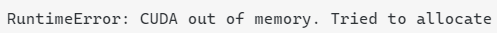

 - 위와 같이 CUDA메모리 부족으로 오류가 나는 것을 확인 할 수 있다. 
 - 이를 해결하기 위해서는 위 cuda의 캐시를 지우는 방식이 있는데 해결될 가능성이 낮다.

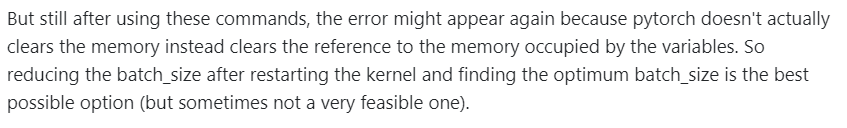

**고로 batch_size를 줄임으로 사용되는 메모리양을 줄이는 방법이 있다.**
- 하지만 이 코드에서는 batch_size가 아닌 데이터 자체의 size를 줄임으로 소모되는 메모리의 양을 줄였다.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])


# 데이터 로드 및 확인

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='/data',
                                        train=True,
                                        download=True,
                                        transform=transform)

testset = torchvision.datasets.CIFAR10(root='/data',
                                       train=False,
                                       download=True,
                                       transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


In [ ]:
train_loader = DataLoader(trainset,
                          batch_size=256,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(testset,
                         batch_size=100,
                         shuffle=True,
                         num_workers=2)

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

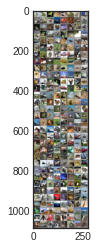

torch.Size([256, 3, 32, 32])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, lables = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(images.shape)

# 신경망 구성

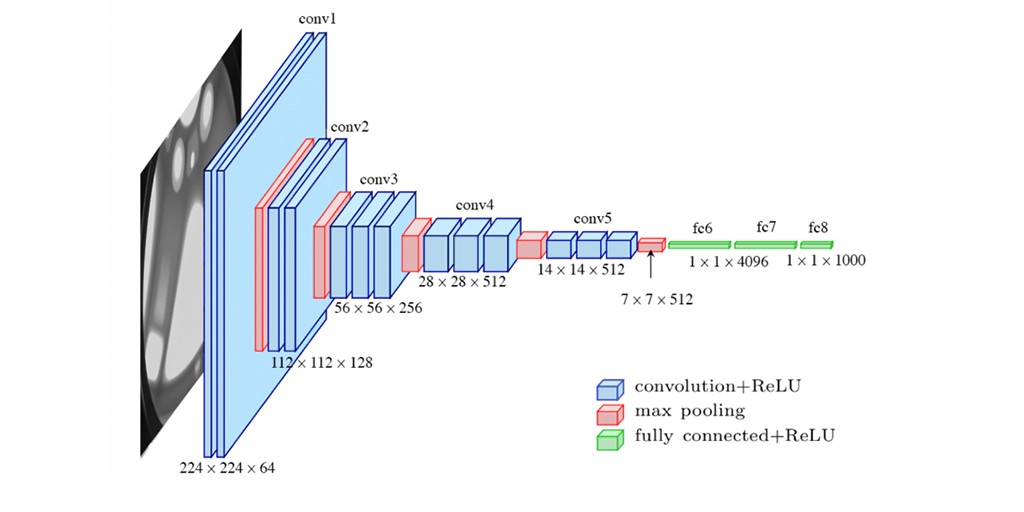

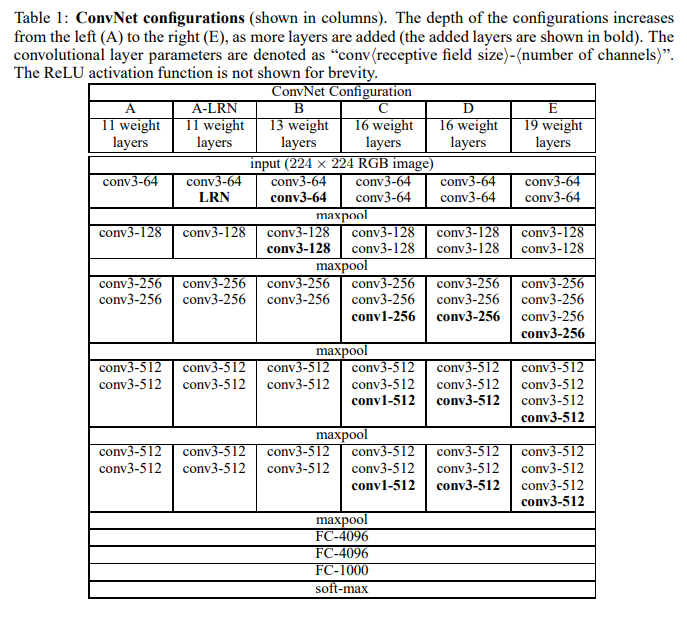

**VGGnet은 여러가지 모델들이 존재한다.**
- 모델 A에서 E로 갈수록 깊이가 점점 깊어지는 것을 확인할 수 있다.
- !) "conv3-128" 이 의미하는 것은 3x3의 filter_size를 가지며, filter의 개수가 128개임을 의미한다.


**필터의 size가 줄어들게 되면서 비선형 함수인 relu가 더 많이 쓰일 수 있게 된다**
 - 다양한 데이터에 대해 유연하게 대처가 가능해진다.
 - 사용되는 파라미터의 개수가 줄어들게 된다.

**VGG 전체 모델 - vgg19모델 사용**

In [ ]:
from torch.nn.modules.dropout import Dropout
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
  def __init__(self, vgg_name, num_classes=10):
    super(VGG, self).__init__()
    self.features = self._make_layers(cfg[vgg_name])

    self.fc_layer = nn.Sequential(
        # cifar10의 size가 32x32이므로
        nn.Linear(512*1*1, 4096),
        # 만약 imagenet대회 데이터인 224x224이라면
        # nn.Linear(512*7*7, 4096)
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 1000),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1000, num_classes)
    )

  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size(0), -1)
    out = self.fc_layer(out)

    return out

  def _make_layers(self, cfg):
    layers = []
    in_channels = 3
    for x in cfg:
      if x == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), 
                   nn.BatchNorm2d(x),   
                   # batchnormalization 층을 사용하는 모델들이 요즘 쓰임
                   # overfitting 억제와 학습속도 개선에 용이하다.
                   nn.ReLU(inplace=True)]
        in_channels = x
    

    return nn.Sequential(*layers)

net = VGG('VGG19').to(device)
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [ ]:
file_name = 'vgg16_cifar10.pth'

In [ ]:
def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += labels.size(0)
        current_correct = (predicted == labels).sum().item()
        correct += current_correct

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current batch average train accuracy:', current_correct / labels.size(0))
            print('Current batch average train loss:', loss.item() / labels.size(0))            
            

# 훈련이 모두 끝난 후 정확도 / 솔실함수 값을 출력  
    print('\nTotal average train accuarcy:', correct / total)
    print('Total average train loss:', train_loss / total)

def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        total += labels.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, labels).item()

        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()

    print('\nTotal average test accuarcy:', correct / total)
    print('Total average test loss:', loss / total)

    state = {
        'net' : net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

In [ ]:
import time
import os

start_time = time.time()

for epoch in range(0, 10):
    train(epoch)
    test(epoch)
    print('\tTime elapsed:', time.time()-start_time)


[ Train epoch: 0 ]

Current batch: 0
Current batch average train accuracy: 0.09765625
Current batch average train loss: 0.009132768958806992

Current batch: 100
Current batch average train accuracy: 0.5234375
Current batch average train loss: 0.005206790752708912

Total average train accuarcy: 0.43054
Total average train loss: 0.005940655114650726

[ Test epoch: 0 ]

Total average test accuarcy: 0.5606
Total average test loss: 0.012273904985189437
Model Saved!
	Time elapsed: 37.013933420181274

[ Train epoch: 1 ]

Current batch: 0
Current batch average train accuracy: 0.5703125
Current batch average train loss: 0.004463702905923128

Current batch: 100
Current batch average train accuracy: 0.65625
Current batch average train loss: 0.0036056656390428543

Total average train accuarcy: 0.669
Total average train loss: 0.00365280837893486

[ Test epoch: 1 ]

Total average test accuarcy: 0.665
Total average test loss: 0.009908640491962432
Model Saved!
	Time elapsed: 67.05213212966919

[ Trai

**Test Accuracy : 78.52%**

**Test Loss : 0.00819**

**걸린 시간 : 약 5분**